In [127]:
import os
import numpy as np
import yaml
import pandas as pd
import textwrap

Simple Functions

In [4]:
def get_yaml_data_from_arxiv_number(arxiv_number):
    with open(os.path.join('..', f'{arxiv_number}', f'{arxiv_number}.yaml'), 'r') as f:
        return yaml.safe_load(f)

In [5]:
with open('../prompt_classification.yaml', 'r') as f:
    prompt_classification = yaml.safe_load(f)

In [419]:
with open('../Task_type.yaml', 'r') as f:
    task_type = yaml.safe_load(f)

In [6]:
is_ambigous_dict = {}
for task in prompt_classification:
    if task['task'] not in is_ambigous_dict:
        if 'placeholder' in task:
            is_ambigous_dict[task['task']] = [key for key,val in task['placeholder'].items() if val == 'A']

In [ ]:
! KEEP IN MIND TO REMOVE "task: Combine the Hartree and Fock term" AND "Construct full Hamiltonian after HF" FROM THE SCORING BECAUSE THEY ARE NOT READABLE CONTENTS FROM THE PAPER"

# Dataset

In [388]:
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]


def get_branch_from_arxiv_number(arxiv_number):
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number=arxiv_number)
    return yaml_data[0]["branch"]


# Keeps the pd.Series nicely ordered from the start
arxiv_number_list.sort(key=get_branch_from_arxiv_number)

# Construct List of Tuple Indices and Data

In [420]:
tuple_index_list = []
score_list = []

for arxiv_number in arxiv_number_list:
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number)

    # Branch name
    cur_branch_name = yaml_data[0]["branch"]

    # Arxiv number
    cur_arxiv_number = arxiv_number

    for task_dict in yaml_data[1:]:
        # Task name
        cur_task_name = task_dict["task"]
        cur_task_type=task_type[cur_task_name]

        for placeholder_name, placeholder_data in task_dict["placeholder"].items():
            # Placeholder name
            cur_placeholder_name = placeholder_name
            is_ambiguous = cur_placeholder_name in is_ambigous_dict.get(cur_task_name, [])

            if "score" in placeholder_data:  # Some entries in tasks don't have a score
                for scorer, score in placeholder_data["score"].items():
                    if scorer in ["Haining","Yasaman"]:
                        cur_scorer = scorer

                        tuple_index_list.append(
                            (
                                cur_branch_name,
                                cur_arxiv_number,
                                cur_task_name,
                                cur_task_type,
                                cur_placeholder_name,
                                is_ambiguous,
                                cur_scorer,
                            )
                        )
                    
                        if score is None:
                            cur_score = '(TODO)'
                            print((cur_arxiv_number,cur_task_name,cur_placeholder_name,cur_scorer))
                        else:
                            cur_score = score
                        score_list.append(cur_score)

('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'system', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'real|momentum', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'single-particle|second-quantized', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'degrees_of_freedom', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'site i and site j with the amplitude hopping', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'kinetic_symbol', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'definition_of_variables', 'Yasaman')
('1106.6060', 'Construct Kinetic Hamiltonian (lattice version)', 'You should ensure the hermiticity of the Hamiltonian', 'Yasaman')
('1106.6060', 'Construct interaction Hamiltonian (real space, lattice version)', 'second_int_symbol', 'Yasaman')
('1106.6060', 'Construct interaction Hamilton

# Create Pandas Series using MultiIndex

In [421]:
index = pd.MultiIndex.from_tuples(tuple_index_list, names=['branch', 'arxiv', 'task','task_type','placeholder', 'is_ambiguous','scorer',])
# data = pd.Series(score_list, index=index, name='score')
data = pd.DataFrame({'Score': score_list}, index=index)
data['Score']=pd.to_numeric(data['Score'],errors='coerce')

In [422]:
def remove(df,level='task', tasks_to_exclude=["Combine the Hartree and Fock term", ]):
    mask = df.index.get_level_values('task').isin(tasks_to_exclude)
    rows_to_keep = ~mask
    df_filtered = df[rows_to_keep]
    df_dropped = df.drop(labels=tasks_to_exclude, level=level)
    return df_dropped


In [423]:
data = remove(data)

In [424]:
data.to_pickle('reading_data.pickle')

In [84]:
data_value_sort=data.xs(key='Haining',level='scorer').groupby('arxiv').mean().sort_values(by='Score')

In [85]:
data_value_sort

,Score
arxiv,
2004.04168,0.611111
1106.6060,0.750000
2308.07488,0.971831
2012.04554,1.022727
1812.04213,1.101695
1010.1819,1.120690
1310.2674,1.163265
2108.02159,1.180328
2110.11330,1.181818


In [86]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Average score')

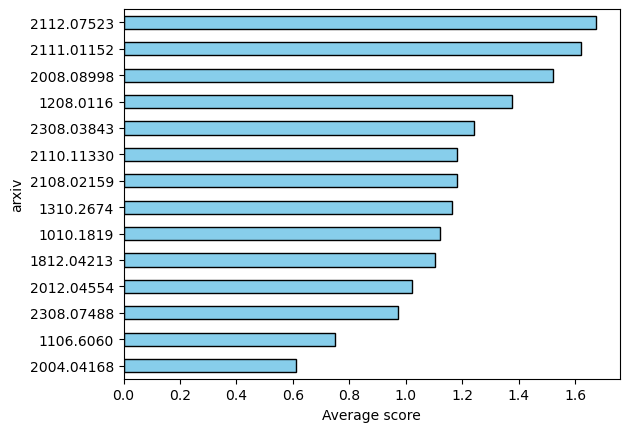

In [87]:
data_value_sort.plot(kind='barh',color='skyblue',edgecolor='k',legend=False)
plt.xlabel('Average score')

In [43]:
data_value_sort.iloc[5:].index

Index(['1812.04213', '1310.2674', '2108.02159', '2110.11330', '2308.03843',
       '1208.0116', '2008.08998', '2111.01152', '2112.07523'],
      dtype='object', name='arxiv')

In [71]:
data_value_sort2=data.xs(key='Haining',level='scorer').groupby(['branch','arxiv']).mean().sort_values(by=['branch','Value'])

In [80]:
pivoted=data_value_sort2.reset_index().pivot(index='arxiv',columns='branch',values='Value')

In [ ]:
bar_width = 0.35
colors = ['skyblue', 'salmon','orange']
labels = pivoted.columns

# Create bar positions
r = np.arange(len(pivoted))
bar_positions = [r, [x + bar_width for x in r]]

# Plot bars for each 'first' group
for idx, label in enumerate(labels):
    plt.barh(bar_positions[idx], pivoted[label], color=colors[idx], label=label, edgecolor='black', height=bar_width)

plt.title('Mean Values by Group')
plt.yticks([r + bar_width for r in range(len(pivoted))], pivoted.index)
plt.ylabel('Second Group')
plt.xlabel('Mean Value')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
['2308.07488','1010.1819','2108.02159','2004.04168','1106.6060']

['2308.07488', '1010.1819', '2108.02159', '2004.04168', '1106.6060']

In [54]:
[x for x in arxiv_number_list if x not in ['2308.07488','1010.1819','2108.02159','2004.04168','1106.6060']]

['1208.0116',
 '2111.01152',
 '2112.07523',
 '1310.2674',
 '1812.04213',
 '2008.08998',
 '2012.04554',
 '2110.11330',
 '2308.03843']

In [18]:
data.to_csv('data.csv')

# Compare different tasks

In [88]:
len(score_list)

757

In [89]:
index.shape

(757,)

In [90]:
reading_literally=["definition_of_variables",'degrees_of_freedom','diagonal_potential','offdiagonal_potential','normalization_factor','int_form','interaction','interaction_degrees_of_freedom','parabolic|Dirac|cos','site i and site j with the amplitude hopping','site i and site j with the interaction strength','system']
reading_with_inferring=["$r$|$k$","Energy_dispersion","For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$","Ham_op","Note that hopping have no position dependence now.",'Note that interaction have no position dependence now','Note that the sublattice degrees of freedom is suppressed for now and will be stated later','Potential_variables','Unsummed_Indices','You should ensure the hermiticity of the Hamiltonian','electrons|holes','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone','real|momentum','single-particle|second-quantized']
background_knowledge=['annihilation_op','bilinear_op','creation_op','definition_of_Fourier_Transformation','hole_annihilation_op','hole_creation_op','hole_op','particle_op','momentum_creation_op','real_creation_op','particle_annihilation_op','particle_creation_op',]
symbols=['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'dispersion_symbol',
 'density_symbol']

In [91]:
len(set(symbols))-len(symbols)

0

In [92]:
occurrence=data.index.get_level_values('placeholder').value_counts().to_dict()

In [93]:
reading_literally_sorted=sorted(reading_literally,key=occurrence.get,reverse=True)
for key in reading_literally_sorted:
    print(f'{key}:{occurrence[key]}')
reading_literally_compare_list=reading_literally_sorted

definition_of_variables:90
degrees_of_freedom:21
system:14
normalization_factor:7
int_form:7
interaction:7
parabolic|Dirac|cos:7
site i and site j with the amplitude hopping:7
site i and site j with the interaction strength:7
diagonal_potential:4
offdiagonal_potential:4
interaction_degrees_of_freedom:4


In [94]:
reading_with_inferring_sorted=sorted(reading_with_inferring,key=occurrence.get,reverse=True)
for key in reading_with_inferring_sorted:
    print(f'{key}:{occurrence[key]}')
reading_with_inferring_compare_list=['single-particle|second-quantized','real|momentum','Energy_dispersion','electrons|holes','Unsummed_Indices','$r$|$k$','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone']

single-particle|second-quantized:25
real|momentum:22
Energy_dispersion:7
For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$:7
Note that hopping have no position dependence now.:7
Note that interaction have no position dependence now:7
You should ensure the hermiticity of the Hamiltonian:7
electrons|holes:7
Unsummed_Indices:6
Note that the sublattice degrees of freedom is suppressed for now and will be stated later:5
$r$|$k$:4
Potential_variables:4
entire_real|first_Brillouin_Zone:2
entire_space|first_Brillouin_zone:2
Ham_op:1


In [95]:
background_knowledge_sorted=sorted(background_knowledge,key=occurrence.get,reverse=True)
for key in background_knowledge_sorted:
    print(f'{key}:{occurrence[key]}')
background_knowledge_compare_list=background_knowledge_sorted[:4]

definition_of_Fourier_Transformation:16
momentum_creation_op:16
real_creation_op:16
bilinear_op:14
annihilation_op:2
creation_op:2
hole_op:2
hole_annihilation_op:1
hole_creation_op:1
particle_op:1
particle_annihilation_op:1
particle_creation_op:1


In [96]:
symbols_sorted=sorted(symbols,key=occurrence.get,reverse=True)
for key in symbols_sorted:
    print(f'{key}:{occurrence[key]}')
symbols_compare_list=symbols_sorted[:10]

Hartree_Fock_second_quantized_symbol:38
second_int_symbol:35
kinetic_symbol:32
Hartree_Fock_symbol:14
Hartree_Fock_term_symbol:14
potential_symbol:12
second_nonint_symbol:12
nonint_symbol:11
Hartree_second_quantized_symbol:9
k_symbol:7
r_symbol:7
In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.:7
Fock_second_quantized_symbol:7
density_symbol:7
matrix_element_symbol:4
basis_symbol:4
dispersion_symbol:2


In [97]:
symbols_compare_list

['Hartree_Fock_second_quantized_symbol',
 'second_int_symbol',
 'kinetic_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'nonint_symbol',
 'Hartree_second_quantized_symbol',
 'k_symbol']

In [98]:
compare_list=['real|momentum','single-particle|second-quantized','degrees_of_freedom','definition_of_variables','definition_of_Fourier_Transformation','system','parabolic|Dirac|cos',]

In [99]:
[index for index in data.index.get_level_values('placeholder').unique() if 'symbol' in index]

['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'dispersion_symbol',
 'density_symbol']

In [100]:
set(data.index.get_level_values('placeholder').unique())-set(symbols)

{'$r$|$k$',
 'Energy_dispersion',
 'For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$',
 'Ham_op',
 'Note that hopping have no position dependence now.',
 'Note that interaction have no position dependence now',
 'Note that the sublattice degrees of freedom is suppressed for now and will be stated later',
 'Potential_variables',
 'Unsummed_Indices',
 'You should ensure the hermiticity of the Hamiltonian',
 'annihilation_op',
 'bilinear_op',
 'creation_op',
 'definition_of_Fourier_Transformation',
 'definition_of_variables',
 'degrees_of_freedom',
 'diagonal_potential',
 'electrons|holes',
 'entire_real|first_Brillouin_Zone',
 'entire_space|first_Brillouin_zone',
 'expected_value',
 'expected_value_Hartree',
 'expected_value_nonzero',
 'expression_Hartree_1',
 'expression_Hartree_2',
 'expression_diag',
 'expression_offdiag',
 'hole_annihilation_op',
 'hole_creation_op',
 'hole_op',
 'index_1',
 'index_2',
 'index_

In [102]:
data.xs(key='Haining',level='scorer')

Score
branch                     arxiv      task                                               placeholder                      is_ambiguous       
continuum, first-quantized 1010.1819  Construct Kinetic Hamiltonian (continuum versio... system                           False           1.0
                                                                                         real|momentum                    False           0.0
                                                                                         single-particle|second-quantized True            0.0
                                                                                         degrees_of_freedom               False           1.0
                                                                                         kinetic_symbol                   False           0.0
...                                                                                                                                       ...
lattice, second-quantized  2308.03843 Reduce momentum in Hartree term (momentum in BZ)   expected_value                   True            2.0
                                                                                         expected_value_nonzero           True            2.0
                                      Reduce momentum in Fock term (momentum in BZ)      Fock_second_quantized_symbol     True            2.0
                                                                                         expected_value                   True            2.0
                                                                                         expected_value_nonzero           True            1.0

[754 rows x 1 columns]

## Comparing results

### Reading ability

In [186]:
data_groupby=data.groupby('placeholder').agg(['mean','sem','count'])

In [195]:
data.loc[pd.IndexSlice[:,:,:,reading_literally_compare_list]].sem().item()

0.041588421885891666

In [187]:
data_groupby.loc[reading_literally_compare_list]

Score                
                                                     mean       sem count
placeholder                                                              
definition_of_variables                          1.634286  0.050804   175
degrees_of_freedom                               1.525000  0.113157    40
system                                           1.740741  0.126227    27
normalization_factor                             1.214286  0.260569    14
int_form                                         1.285714  0.244243    14
interaction                                      1.071429  0.266526    14
parabolic|Dirac|cos                              1.428571  0.250588    14
site i and site j with the amplitude hopping     1.538462  0.243252    13
site i and site j with the interaction strength  1.769231  0.121626    13
diagonal_potential                               0.500000  0.327327     8
offdiagonal_potential                            1.750000  0.250000     8
interaction_degrees_of_freedom                   0.500000  0.267261     8

In [207]:
f'Reading Literally (mean={data.loc[pd.IndexSlice[:,:,:,reading_literally_compare_list]].mean().item():.2f})'

'Reading Literally (mean=1.52)'

In [218]:
tasks

dict_keys(['system', 'site i and site j with the interaction strength', 'definition_of_variables', 'degrees_of_freedom', 'offdiagonal_potential', 'site i and site j with the amplitude hopping', 'parabolic|Dirac|cos', 'normalization_factor', 'int_form', 'interaction', 'interaction_degrees_of_freedom', 'diagonal_potential'])

In [219]:
reading_literally_compare_list

['definition_of_variables',
 'degrees_of_freedom',
 'system',
 'normalization_factor',
 'int_form',
 'interaction',
 'parabolic|Dirac|cos',
 'site i and site j with the amplitude hopping',
 'site i and site j with the interaction strength',
 'diagonal_potential',
 'offdiagonal_potential',
 'interaction_degrees_of_freedom']

Index(['diagonal_potential', 'interaction_degrees_of_freedom', 'interaction',
       'normalization_factor', 'int_form', 'parabolic|Dirac|cos',
       'degrees_of_freedom', 'site i and site j with the amplitude hopping',
       'definition_of_variables', 'system', 'offdiagonal_potential',
       'site i and site j with the interaction strength'],
      dtype='object', name='placeholder')

In [259]:
def plot_bar(compare_list,df_groupby,title,width=25):
    ax=df_groupby.loc[compare_list]['Score']['mean'].sort_values().plot(kind='barh',color='skyblue',edgecolor='k',xerr=df_groupby.loc[compare_list]['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
    ax.grid(axis='x',ls='--')
    ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=width)) for task in df_groupby.loc[compare_list]['Score']['mean'].sort_values().index],fontsize=7)
    ax.set_ylabel('')
    ax.set_xlabel('Score')
    ax.set_title(f'{title} (mean={df_groupby.loc[compare_list]["Score"]["mean"].mean():.2f})')

['diagonal_potential', 'interaction_degrees_of_fr\needom', 'interaction', 'normalization_factor', 'int_form', 'parabolic|Dirac|cos', 'degrees_of_freedom', 'site i and site j with\nthe amplitude hopping', 'definition_of_variables', 'system', 'offdiagonal_potential', 'site i and site j with\nthe interaction strength']


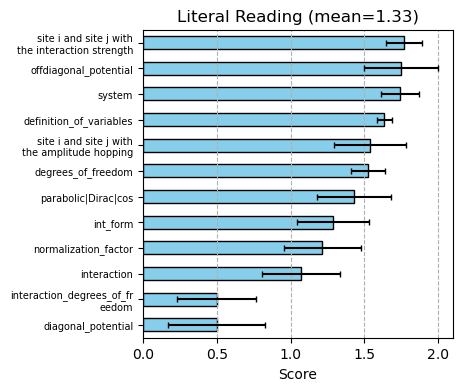

In [260]:
plot_bar(reading_literally_compare_list, data_groupby, 'Literal Reading')

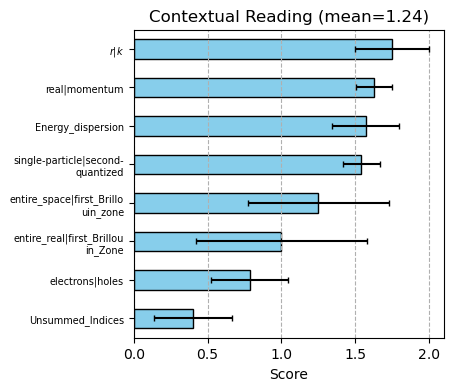

In [228]:
plot_bar(reading_with_inferring_compare_list, data_groupby, 'Contextual Reading')

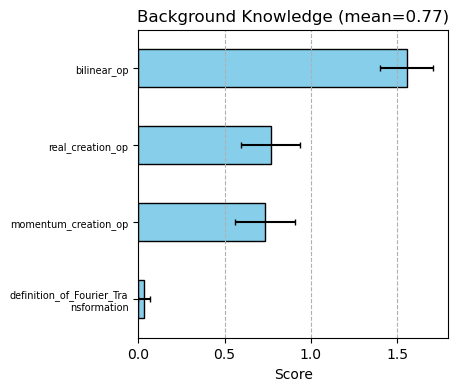

In [229]:
plot_bar(background_knowledge_compare_list, data_groupby, 'Background Knowledge')

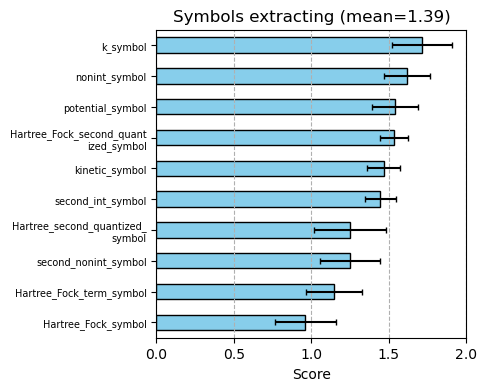

In [230]:
plot_bar(symbols_compare_list, data_groupby, 'Symbols extracting')

# Score by task

In [249]:
with open('../Naming.yaml','r') as f:
    naming=yaml.safe_load(f)

In [428]:
task_type_order=['Hamiltonian of QMB problem','Hamiltonian in momentum space','Mean field decomposition','Hartree and Fock terms','Order parameter']

In [429]:
# data_groupby_task=data.groupby('task').agg(['mean','sem','count'])
data_groupby_task=data.groupby('task_type').agg(['mean','sem','count'])
data_groupby_task=data_groupby_task.loc[task_type_order[::-1]]

In [430]:
# data_groupby_task_common=data_groupby_task[data_groupby_task['Score']['count']>=28].sort_values(by=('Score','mean'),)
data_groupby_task_common=data_groupby_task[data_groupby_task['Score']['count']>=28]

In [ ]:
ax=data_groupby_task_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_task_common['Score']['sem'],legend=False,figsize=(4, 6),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(naming[task], width=40)) for task in data_groupby_task_common['Score']['mean'].index],fontsize=7)

[Text(0, 0, 'Order parameter'),
 Text(0, 1, 'Hartree and\nFock terms'),
 Text(0, 2, 'Mean field\ndecomposition'),
 Text(0, 3, 'Hamiltonian in\nmomentum space'),
 Text(0, 4, 'Hamiltonian of\nQMB problem')]

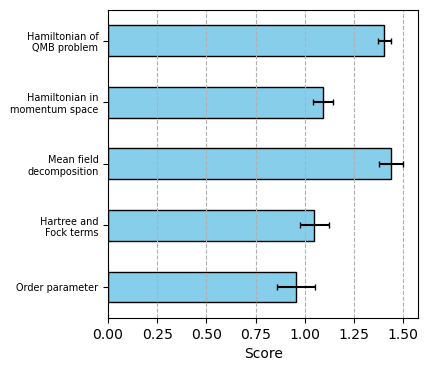

In [431]:
ax=data_groupby_task_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_task_common['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=15)) for task in data_groupby_task_common['Score']['mean'].index],fontsize=7)

# Score by branch

In [282]:
data_groupby_branch=data.groupby('branch').agg(['mean','sem','count'])

[Text(0, 0, 'lattice, second-\nquantized'),
 Text(0, 1, 'continuum, first-\nquantized'),
 Text(0, 2, 'continuum, second-\nquantized')]

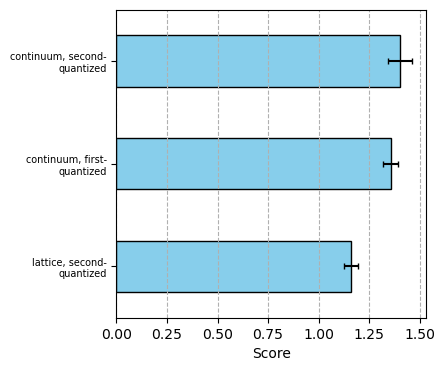

In [279]:
ax=data_groupby_branch['Score']['mean'].sort_values().plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_branch['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in data_groupby_branch['Score']['mean'].sort_values().index],fontsize=7)

# Score by ambiguity

In [336]:
data_groupby_ambi=data.groupby('is_ambiguous').agg(['mean','sem','count'])

In [365]:
data_am_groupby_ph=data.xs(key=True,level='is_ambiguous').groupby('placeholder').agg(['mean','sem','count'])
data_unam_groupby_ph=data.xs(key=False,level='is_ambiguous').groupby('placeholder').agg(['mean','sem','count'])
data_am_group_ph_common=data_am_groupby_ph[data_am_groupby_ph['Score']['count']>=10].sort_values(by=('Score','mean'))
data_unam_group_ph_common=data_unam_groupby_ph[data_unam_groupby_ph['Score']['count']>=10].sort_values(by=('Score','mean'))

Text(0.5, 1.0, 'Ambiguous (mean=1.19$\\pm$0.21)')

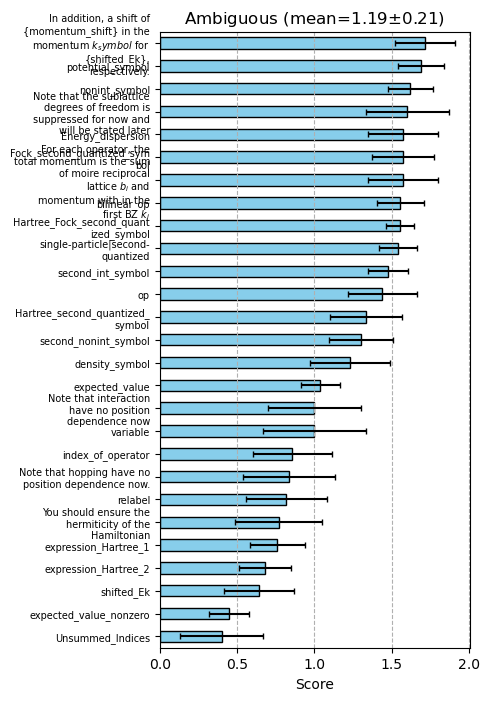

In [366]:
ax=data_am_group_ph_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_am_group_ph_common['Score']['sem'],legend=False,figsize=(4, 8),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=25)) for task in data_am_group_ph_common['Score']['mean'].index],fontsize=7)
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_title(f'Ambiguous (mean={data_am_group_ph_common["Score"]["mean"].mean():.2f}$\pm${data_am_group_ph_common["Score"]["sem"].mean():.2f})')

Text(0.5, 1.0, 'Unambiguous (mean=1.22$\\pm$0.18)')

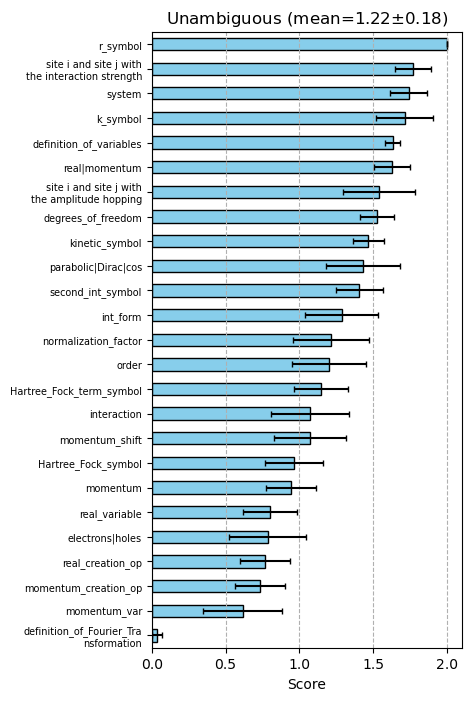

In [368]:
ax=data_unam_group_ph_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_unam_group_ph_common['Score']['sem'],legend=False,figsize=(4, 8),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=25)) for task in data_unam_group_ph_common['Score']['mean'].index],fontsize=7)
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_title(f'Unambiguous (mean={data_unam_group_ph_common["Score"]["mean"].mean():.2f}$\pm${data_unam_group_ph_common["Score"]["sem"].mean():.2f})')

In [284]:
data_groupby_ambi

Score                
                  mean       sem count
is_ambiguous                          
False         1.279805  0.031735   822
True          1.253543  0.036015   635

In [237]:
data_groupby_task.sort_values(by=('Score','count'),ascending=False)

Score                
                                                        mean       sem count
task                                                                        
Define each term in Kinetic Hamiltonian (contin...  1.428571  0.073205   140
Construct interaction Hamiltonian (momentum space)  1.198413  0.085092   126
Extract quadratic term                              1.509259  0.077267   108
Construct Kinetic Hamiltonian (lattice version)     1.701923  0.065359   104
Convert interacting Hamiltonian in real space t...  0.864078  0.095639   103
Convert noninteracting Hamiltonian in real spac...  0.844444  0.099826    90
Construct Kinetic Hamiltonian (continuum versio...  1.277778  0.096153    90
Wick's theorem                                      1.345679  0.099630    81
Construct interaction Hamiltonian (real space, ...  1.448718  0.090596    78
Swap the index only                                 0.938462  0.117827    65
Construct Potential Hamiltonian (continuum vers...  1.250000  0.122871    56
Convert from single-particle to second-quantize...  1.428571  0.113553    56
Swap the index to combine Hartree and Fock terms    1.053571  0.120657    56
Construct Kinetic Hamiltonian (continuum versio...  1.477273  0.123757    44
Expand interaction                                  1.300000  0.144115    40
Define each term in Potential Hamiltonian (cont...  1.500000  0.113228    40
Convert from single-particle to second-quantize...  1.468750  0.141879    32
Reduce momentum in Fock term (momentum in BZ + ...  0.766667  0.156714    30
Reduce momentum in Hartree term (momentum in BZ...  0.966667  0.169403    30
Convert noninteracting Hamiltonian in real spac...  0.857143  0.190476    28
Particle-hole transformation                        1.687500  0.176039    16
Reduce momentum in Hartree term (momentum in BZ)    1.066667  0.248168    15
Simplify the Hamiltonian in the particle-hole b...  1.928571  0.071429    14
Reduce momentum in Fock term (momentum in BZ)       1.250000  0.250000    12
Hartree term only                                   0.000000  0.000000     3

In [142]:
reading_literally_score={scorer:{ph:data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Score'].mean() for ph in reading_literally_compare_list} for scorer in ['Haining',]}
reading_literally_score_se={scorer:{ph:data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Score'].sem() for ph in reading_literally_compare_list} for scorer in ['Haining',]}
# reading_literally_score={ph:data_mean.xs(key=ph,level='placeholder')['Score'].mean() for ph in reading_literally_compare_list}

In [113]:
# sorted_keys = [list(reading_literally_score['Haining'].keys())[i] for i in np.argsort(np.array(list(reading_literally_score['Haining'].values()))+np.array(list(reading_literally_score['Yasaman'].values())))[::-1]]
sorted_keys = [list(reading_literally_score['Haining'].keys())[i] for i in np.argsort(np.array(list(reading_literally_score['Haining'].values())))[::-1]]


In [114]:
reading_literally_score_sorted={scorer:{k: reading_literally_score[scorer][k] for k in sorted_keys} for scorer in reading_literally_score.keys()}

In [ ]:
reading_literally_score_sorted['Haining'].keys()==reading_literally_score_sorted['Yasaman'].keys()

In [116]:
import matplotlib.pyplot as plt
import numpy as np

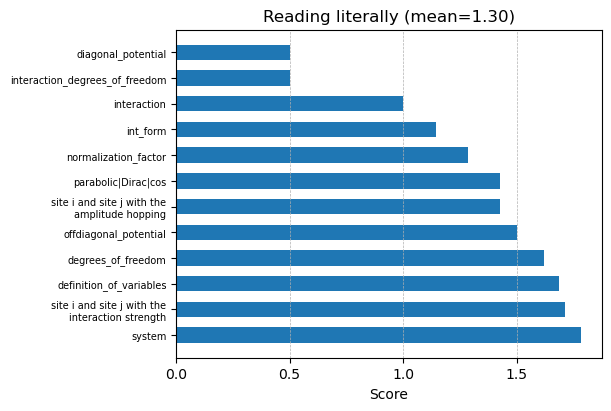

In [139]:
tasks=reading_literally_score_sorted['Haining'].keys()

x = np.arange(len(reading_literally_score_sorted['Haining'].keys()))  # the label locations
width = 0.6  # the width of the bars
multiplier = 1

fig, ax = plt.subplots(layout='constrained',figsize=(6,4))

for attribute, measurement in reading_literally_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute,xerr=)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks(np.arange(0,2,0.5))

ax.set_title(f'Reading literally (mean={np.mean([list(val.values()) for val in reading_literally_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)
ax.set_yticks(x + width, ['\n'.join(textwrap.wrap(task, width=30)) for task in tasks],fontsize=7)

handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)



### Reading_with_inferring

In [190]:
reading_with_inferring_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in reading_with_inferring_compare_list} for scorer in ['Haining','Yasaman']}

In [192]:
sorted_keys = [list(reading_with_inferring_score['Haining'].keys())[i] for i in np.argsort(np.array(list(reading_with_inferring_score['Haining'].values()))+np.array(list(reading_with_inferring_score['Yasaman'].values())))[::-1]]

In [193]:
reading_with_inferring_score_sorted={scorer:{k: reading_with_inferring_score[scorer][k] for k in sorted_keys} for scorer in ['Haining','Yasaman']}

In [195]:
reading_with_inferring_score_sorted['Haining'].keys()==reading_with_inferring_score_sorted['Yasaman'].keys()

True

In [196]:
np.mean([list(val.values()) for val in reading_with_inferring_score_sorted.values()])

1.2731580557124036

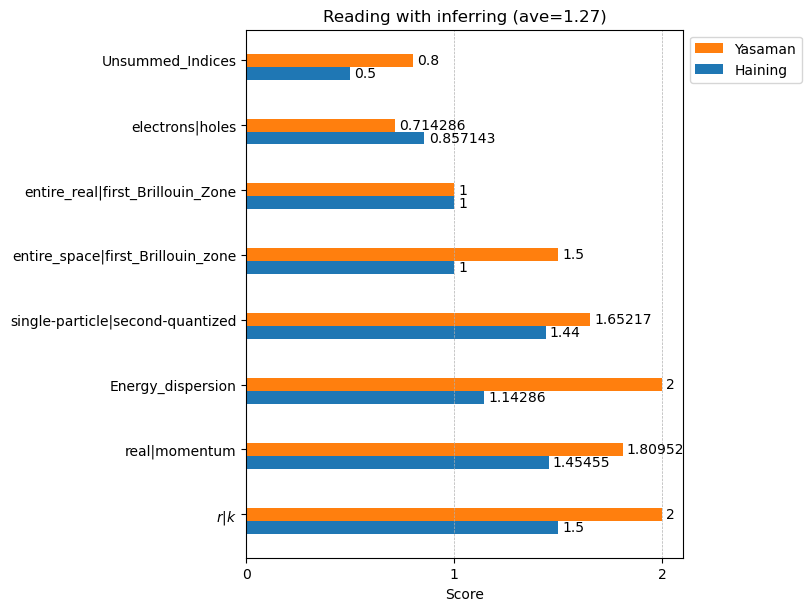

In [212]:
tasks=reading_with_inferring_score_sorted['Haining'].keys()

x = np.arange(len(reading_with_inferring_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in reading_with_inferring_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Reading with inferring (mean={np.mean([list(val.values()) for val in reading_with_inferring_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)



### background_knowledge_sorted

In [205]:
background_knowledge_sorted

['definition_of_Fourier_Transformation',
 'momentum_creation_op',
 'real_creation_op',
 'bilinear_op',
 'annihilation_op',
 'creation_op',
 'hole_op',
 'hole_annihilation_op',
 'hole_creation_op',
 'particle_op',
 'particle_annihilation_op',
 'particle_creation_op']

In [206]:
background_knowledge_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in background_knowledge_compare_list} for scorer in ['Haining','Yasaman']}

In [207]:
sorted_keys = [list(background_knowledge_score['Haining'].keys())[i] for i in np.argsort(np.array(list(background_knowledge_score['Haining'].values()))+np.array(list(background_knowledge_score['Yasaman'].values())))[::-1]]

In [208]:
background_knowledge_score_sorted={scorer:{k: background_knowledge_score[scorer][k] for k in sorted_keys} for scorer in ['Haining','Yasaman']}

In [209]:
np.mean([list(val.values()) for val in background_knowledge_score_sorted.values()])

0.7733516483516483

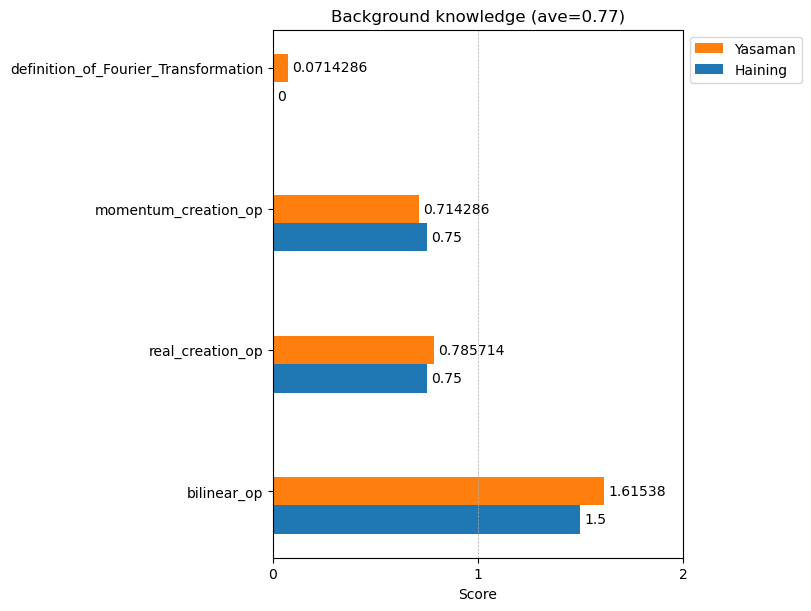

In [211]:
tasks=background_knowledge_score_sorted['Haining'].keys()

x = np.arange(len(background_knowledge_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in background_knowledge_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Background knowledge (mean={np.mean([list(val.values()) for val in background_knowledge_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)



### symbols_sorted

In [215]:
symbols_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in symbols_compare_list} for scorer in ['Haining','Yasaman']}

In [216]:
sorted_keys = [list(symbols_score['Haining'].keys())[i] for i in np.argsort(np.array(list(symbols_score['Haining'].values()))+np.array(list(symbols_score['Yasaman'].values())))[::-1]]

In [218]:
symbols_score_sorted={scorer:{k: symbols_score[scorer][k] for k in sorted_keys} for scorer in ['Haining','Yasaman']}

In [219]:
np.mean([list(val.values()) for val in symbols_score_sorted.values()])

1.3669941462046724

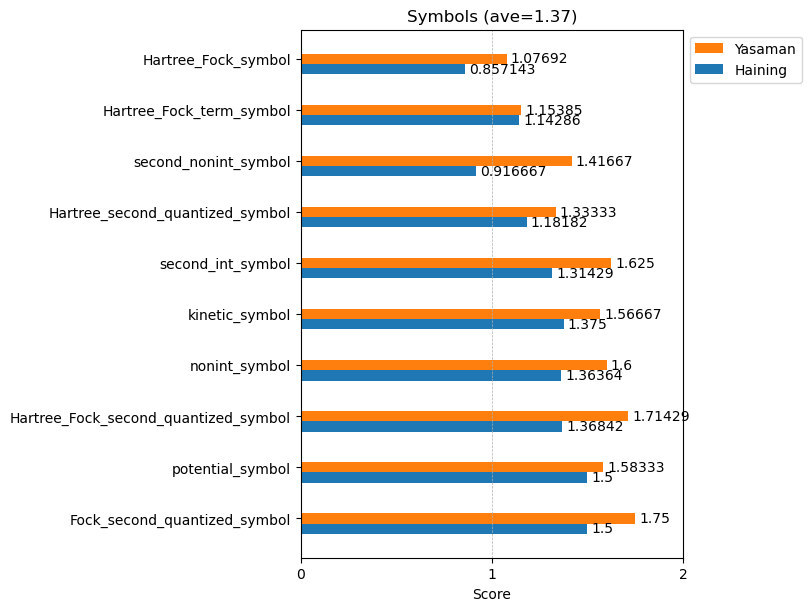

In [221]:
tasks=symbols_score_sorted['Haining'].keys()

x = np.arange(len(symbols_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in symbols_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Symbols (mean={np.mean([list(val.values()) for val in symbols_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

